In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os
from training.feature_extraction import extract_features  # your multi-dim function
from training.preprocess import _group_and_window
from utils.bilstm import data_reshape
project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))  # return the projest's root folder
sys.path.append(project_root)
from utils import data_reshape, split_helper, load_parameters

2025-04-14 12:56:35.206089: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 12:56:35.206958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 12:56:35.209589: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 12:56:35.216821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744628195.229008 1397744 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744628195.23

In [2]:
import pandas as pd
import numpy as np
import pickle
from functools import partial
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#!/usr/bin/env python
# coding: utf-8

"""
A script/notebook to compare BiLSTM vs LightGBM across multiple window sizes
for one or more datasets (e.g. 'st', 'randomized').
Assumes:
 - Each window-specific BiLSTM model is saved at models/bilstm/{dataset}_bilstm_win{w}.h5
 - The single LightGBM model is saved at models/lightgbm/{dataset}_model.pkl
 - multi_window_size is defined in your .yaml files
 - The same data_path + CSV structure is used for test sets
"""
from tensorflow.keras.metrics import MeanAbsoluteError
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# Local modules (adjust imports if your structure is different)
from training.preprocess import preprocess_and_window, load_parameters
from training.feature_extraction import extract_features

In [3]:
# BILSTM model -----------------------------------------------------------------------
# the input features of the BiLSTM model
features_bilstm = ['voltage', 'current', 'temperature', 'relativeTime']
labels_bilstm = ['capacity']

# load the model


# the BiLSTM model's input features need to be normalized
folder_path = 'data/st/'
path_dict = {'train': f'{folder_path}train.csv',
             'valid': f'{folder_path}valid.csv',
             'test': f'{folder_path}test.csv'}
data_dict = {key: pd.read_csv(path) for key, path in path_dict.items()}
data = pd.concat(data_dict, axis=0)
scaler = MinMaxScaler()
data[features_bilstm] = scaler.fit_transform(data[features_bilstm])
# split tha dataset into train, valid, test
#unique_cycles = data['cycle'].unique()
# Example: 70% train+val, 30% test
#trainval_cycles, test_cycles = train_test_split(
#    unique_cycles, test_size=0.2, random_state=42
#)
test_lgb = pd.read_csv('data/st/test.csv')
# BILSTM model ------------------------------------------------------------------------



In [4]:
train = pd.read_csv('data/st/train.csv')
valid = pd.read_csv('data/st/valid.csv')
test_bilstm = pd.read_csv('data/st/test.csv')

scaler = MinMaxScaler()
train[features_bilstm] = scaler.fit_transform(train[features_bilstm])
valid[features_bilstm] = scaler.transform(valid[features_bilstm])


In [5]:
# LightGBM model -----------------------------------------------------------------------
# the input features of the LightGBM model
params = load_parameters('training/lightgbm.yaml').datasets['st']
features_lgb = params['feature_list']
labels_lgb = params['labels']

# load the model
# with open('model_lightgbm/model_pruning/pruned_nasa_3features_first20_01886500/pruned_110trees_0199.pkl', 'rb') as file:
#     model_lgb = pickle.load(file)
with open('models/lightgbm/lgbm_st_model.pkl', 'rb') as file:
    model_lgb = pickle.load(file)

# the testing data
test_lgb = pd.read_csv('data/st/test.csv')
# LightGBM model -----------------------------------------------------------------------

In [6]:
data_groupby = params['data_groupby']
# step_len_list = [5, 10, 15, 20, 30, 40, 50, 70, 100]
step_len_list = [20]
# step_len_list = [5, 10, 15, 20, 30, 40, 50]

# get the group size
group_sizes = test_lgb.groupby(data_groupby).size()
max_group_length, min_group_length = group_sizes.max(), group_sizes.min()
print(f"--group length: max={max_group_length}, min={min_group_length}\n")
fixed_group_length = min_group_length

# test and save the result onto dataframe
columns = ['model', 'step_length', 'ordinal', 'MAE', 'loss']
result = pd.DataFrame(columns=columns)

--group length: max=360, min=175



/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with featur

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


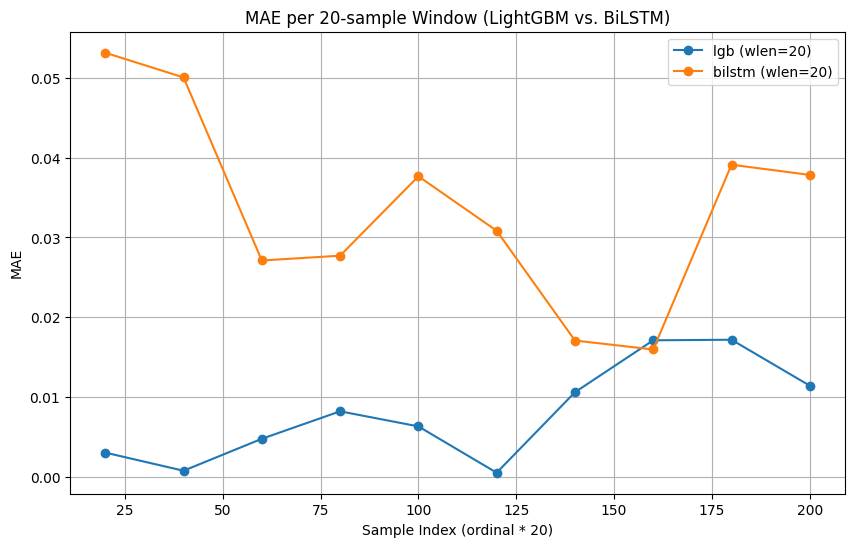

LightGBM - overall MAE at wlen=20: 0.0161
BiLSTM   - overall MAE at wlen=20: 0.0174


In [7]:
# ---------------------------------------------------------------------
# 5) Build 20-sample windows from the test set
# ---------------------------------------------------------------------
step_len = 20  # Your chosen fixed window length
overlap = 0    # No overlap, so it slices [0..19], [20..39], etc.

X_list, y_list = _group_and_window(
    df=test_lgb,  # test data
    features=params['raw_features'],   # columns used as raw input
    labels=params['labels'],           # columns for target
    window_length=step_len,
    overlap=overlap,
    group_cols=params['data_groupby']
)
# X_list is a list of arrays each shaped (20, len(raw_features))
# y_list is a list of scalars (if 1D label)

if len(X_list) == 0:
    print("No 20-sample windows created from the test data. Exiting.")
    exit()

# Convert to NumPy
X_test_windows = np.array(X_list)    # shape => (N_windows, 20, len(raw_features))
y_test_windows = np.array(y_list)    # shape => (N_windows,)

X_test_windows_bilstm = np.array([scaler.transform(X_list[i]) for i in range(len(X_list))])
# ---------------------------------------------------------------------
# 6) LightGBM Prediction: First extract features from (N_windows, 20, #features)
# ---------------------------------------------------------------------
X_test_lgb = extract_features(
    data=X_test_windows,
    raw_features=params['raw_features'],
    feature_list=params['feature_list']
)
# shape => (N_windows, extracted_feature_dim)

preds_lgb = model_lgb.predict(X_test_lgb)  # shape => (N_windows,)

# Per-window absolute errors
abs_err_lgb = np.abs(preds_lgb.ravel() - y_test_windows.ravel())


model_bilstm_path = 'models/bilstm/st_bilstm_'
model_bilstm_dict = {
    '5': f'{model_bilstm_path}win5.h5',
    '10': f'{model_bilstm_path}win10.h5',
    #'15': f'{model_bilstm_path}15.keras',
    '20': f'{model_bilstm_path}win20.h5',
    #'20': f'download/ST_BiLSTM_st.keras',
    '30': f'{model_bilstm_path}win30.h5',
    '40': f'{model_bilstm_path}win40.h5',
    '50': f'{model_bilstm_path}win50.h5',
}
model_bilstm = tf.keras.models.load_model(model_bilstm_dict['20'], custom_objects={'mae': MeanAbsoluteError()})
# ---------------------------------------------------------------------
# 7) BiLSTM Prediction: Feed raw (N_windows, 20, #features) directly
# ---------------------------------------------------------------------
preds_bilstm = model_bilstm.predict(X_test_windows_bilstm)  # shape => (N_windows,)
abs_err_bilstm = np.abs(preds_bilstm.ravel() - y_test_windows.ravel())


# ---------------------------------------------------------------------
# 8) Build a result DataFrame and plot the per-window MAE
# ---------------------------------------------------------------------
N_windows = len(X_test_windows)

results = []
for i in range(N_windows):
    # "ordinal" is just the i-th window (1-based index)
    ordinal = i + 1
    results.append({
        "model": "lgb",
        "step_length": step_len,
        "ordinal": ordinal,
        "MAE": abs_err_lgb[i]
    })
    results.append({
        "model": "bilstm",
        "step_length": step_len,
        "ordinal": ordinal,
        "MAE": abs_err_bilstm[i]
    })

df_results = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 6))
plt.title(f"MAE per 20-sample Window (LightGBM vs. BiLSTM)")

for model_name in df_results["model"].unique():
    # Subset for each model
    subset = df_results[df_results["model"] == model_name]
    # For X, you can multiply ordinal by 20 to reflect the sample index in the series
    xvals = subset["ordinal"] * step_len
    yvals = subset["MAE"]
    plt.plot(
        xvals[:10], 
        yvals[:10],
        marker="o",
        linestyle="-",
        label=f"{model_name} (wlen=20)"
    )

plt.xlabel("Sample Index (ordinal * 20)")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()


# ---------------------------------------------------------------------
# 9) (Optional) Print Overall MAE
# ---------------------------------------------------------------------
avg_mae_lgb = abs_err_lgb.mean()
avg_mae_bilstm = abs_err_bilstm.mean()
print(f"LightGBM - overall MAE at wlen=20: {avg_mae_lgb:.4f}")
print(f"BiLSTM   - overall MAE at wlen=20: {avg_mae_bilstm:.4f}")



=== Evaluating dataset: st ===

Window sizes to evaluate: [10, 20, 30, 40, 50]

--- Window size = 10 ---
  BILSTM Test data shape: (851, 10, 4)
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  BILSTM Test MAE: 0.018947


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (851, 6)
  LightGBM Test MAE: 0.018440

--- Window size = 20 ---
  BILSTM Test data shape: (416, 20, 4)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
  BILSTM Test MAE: 0.026323


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (416, 6)
  LightGBM Test MAE: 0.016108

--- Window size = 30 ---
  BILSTM Test data shape: (269, 30, 4)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
  BILSTM Test MAE: 0.032441
  LightGBM Test data shape (extracted features): (269, 6)
  LightGBM Test MAE: 0.014687

--- Window size = 40 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (203, 40, 4)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
  BILSTM Test MAE: 0.041561


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (203, 6)
  LightGBM Test MAE: 0.012439

--- Window size = 50 ---
  BILSTM Test data shape: (160, 50, 4)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
  BILSTM Test MAE: 0.044467
  LightGBM Test data shape (extracted features): (160, 6)
  LightGBM Test MAE: 0.014917


=== Evaluating dataset: randomized ===

Window sizes to evaluate: [10, 20, 30, 40, 50]


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Window size = 10 ---


  BILSTM Test data shape: (699, 10, 4)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  BILSTM Test MAE: 1.180275
  LightGBM Test data shape (extracted features): (699, 13)
  LightGBM Test MAE: 3.007698

--- Window size = 20 ---
  BILSTM Test data shape: (340, 20, 4)


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
  BILSTM Test MAE: 3.103860
  LightGBM Test data shape (extracted features): (340, 13)
  LightGBM Test MAE: 3.100503

--- Window size = 30 ---
  BILSTM Test data shape: (218, 30, 4)


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
  BILSTM Test MAE: 4.544897
  LightGBM Test data shape (extracted features): (218, 13)
  LightGBM Test MAE: 2.818352

--- Window size = 40 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (161, 40, 4)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  BILSTM Test MAE: 17.645146
  LightGBM Test data shape (extracted features): (161, 13)
  LightGBM Test MAE: 3.059393

--- Window size = 50 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (123, 50, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
  BILSTM Test MAE: 17.734785
  LightGBM Test data shape (extracted features): (123, 13)
  LightGBM Test MAE: 2.213407


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


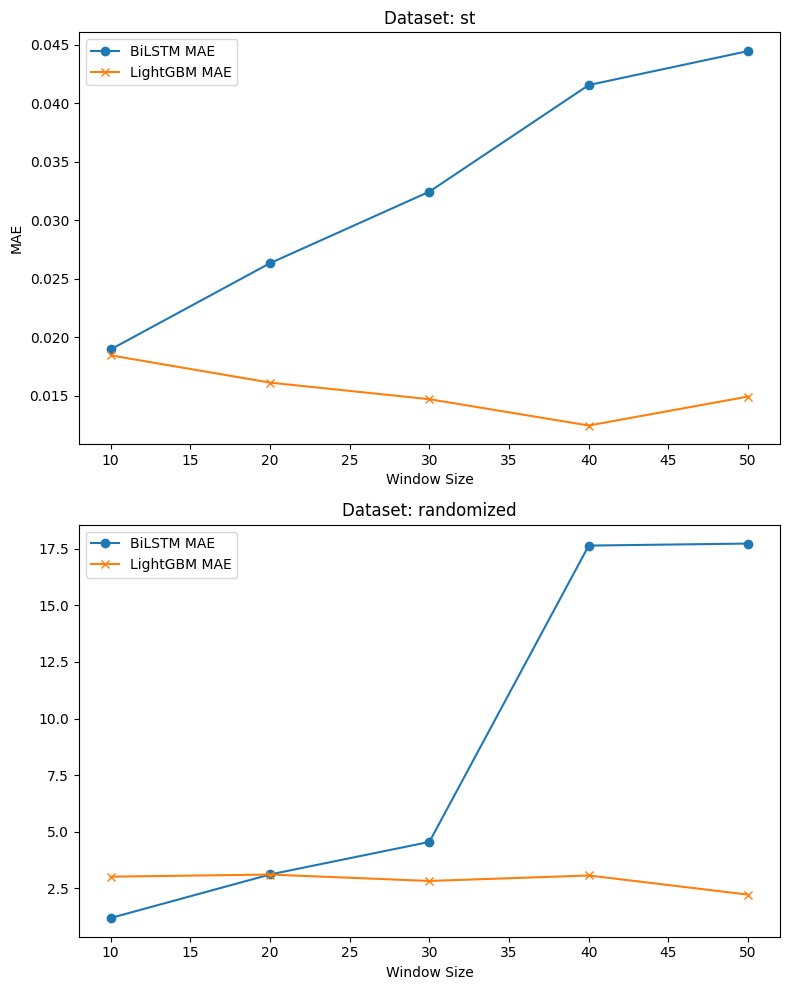

In [241]:


##############################################################################
# 1) Choose which datasets to evaluate
##############################################################################
# If you only have 'st' and 'randomized', set them here:
DATASETS = ["st", "randomized"]  # or just ["st"] if you only want one.

##############################################################################
# 2) Prepare a figure for subplots (one subplot per dataset)
##############################################################################
fig, axes = plt.subplots(nrows=len(DATASETS), ncols=1, figsize=(8, 5 * len(DATASETS)), sharex=False, sharey=False)

if not isinstance(axes, np.ndarray):
    # If there's only one dataset in the list, 'axes' won't be an array.
    axes = [axes]  # make it iterable

##############################################################################
# 3) Loop over each dataset, evaluate BiLSTM vs LightGBM across windows
##############################################################################
for i, ds_name in enumerate(DATASETS):
    ax = axes[i]
    print(f"\n\n=== Evaluating dataset: {ds_name} ===\n")

    ##########################################################################
    # 3.1) Load configurations for BiLSTM and LightGBM
    #      We'll read both YAML files to get the needed info.
    ##########################################################################
    params_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)
    params_lgb    = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)

    # We'll gather the window sizes from the same config you used to train them.
    # Typically, you'd find these in both configs, or just pick one of them.
    window_sizes = []
    if hasattr(params_bilstm, "multi_window_size"):
        window_sizes = params_bilstm.multi_window_size[1:]
    elif hasattr(params_lgb, "multi_window_size"):
        window_sizes = params_lgb.multi_window_size[1:]
    else:
        # fallback if no multi_window_size
        window_sizes = [params_bilstm.sequence_length]

    print(f"Window sizes to evaluate: {window_sizes}")

    ##########################################################################
    # 3.2) Load LightGBM model
    ##########################################################################
    lgbm_model_path = f"models/lightgbm/lgbm_{ds_name}_model.pkl"
    if not os.path.exists(lgbm_model_path):
        print(f"WARNING: LightGBM model not found: {lgbm_model_path}")
        print("Skipping LightGBM evaluation...")
        lgbm_maes = [None] * len(window_sizes)
        lightgbm_available = False
    else:
        with open(lgbm_model_path, "rb") as f:
            lgbm_model = pickle.load(f)
        lightgbm_available = True
        lgbm_maes = []

    ##########################################################################
    # 3.3) Evaluate BiLSTM across multiple window sizes
    ##########################################################################
    bilstm_maes = []
    for w in window_sizes:
        print(f"\n--- Window size = {w} ---")

        ######################################################################
        # (a) Prepare test data for that window
        ######################################################################
        # BILSTM uses the raw numeric windows from `params_bilstm.features`
        ( _, _, _, _, test_s_bi, test_t_bi) = preprocess_and_window(
            data_path    = params_bilstm.data_path,
            sequence_length = w,
            overlap      = params_bilstm.overlap,
            normalize    = params_bilstm.normalize,
            features     = params_bilstm.features,
            labels       = params_bilstm.labels,
            data_groupby = params_bilstm.data_groupby
        )

        print(f"  BILSTM Test data shape: {test_s_bi.shape}")

        # (b) Load the BiLSTM model for this window size
        bilstm_path = f"models/bilstm/{ds_name}_bilstm_win{w}.h5"
        if not os.path.exists(bilstm_path):
            print(f"  WARNING: BiLSTM model not found at {bilstm_path}")
            bilstm_maes.append(None)
        else:
            
            bilstm_model = tf.keras.models.load_model(bilstm_path, custom_objects={'mae': MeanAbsoluteError()})
            pred_bi = bilstm_model.predict(test_s_bi)
            mae_bi = mean_absolute_error(test_t_bi, pred_bi)
            bilstm_maes.append(mae_bi)
            print(f"  BILSTM Test MAE: {mae_bi:.6f}")

        ######################################################################
        # (c) Evaluate LightGBM for this window size (same test *samples*)
        ######################################################################
        if lightgbm_available:
            # LightGBM was trained on extracted features, so do the same extraction
            ( _, _, _, _, test_s_lgb, test_t_lgb) = preprocess_and_window(
                data_path    = params_lgb.data_path,
                sequence_length = w,
                overlap      = params_lgb.overlap,
                normalize    = params_lgb.normalize,
                features     = params_lgb.raw_features,
                labels       = params_lgb.labels,
                data_groupby = params_lgb.data_groupby
            )
            # Convert raw windows to final feature set
            test_s_lgb = extract_features(test_s_lgb, params_lgb.raw_features, params_lgb.feature_list)
            print(f"  LightGBM Test data shape (extracted features): {test_s_lgb.shape}")

            lgb_pred = lgbm_model.predict(test_s_lgb)
            mae_lgb = mean_absolute_error(test_t_lgb, lgb_pred)
            lgbm_maes.append(mae_lgb)
            print(f"  LightGBM Test MAE: {mae_lgb:.6f}")

    ##########################################################################
    # 3.4) Plot the results for this dataset
    ##########################################################################
    # Some datasets might not have valid LightGBM or BILSTM arrays, so handle that:
    if len(bilstm_maes) == len(window_sizes):
        ax.plot(window_sizes, bilstm_maes, marker='o', label='BiLSTM MAE')
    if lightgbm_available and len(lgbm_maes) == len(window_sizes):
        ax.plot(window_sizes, lgbm_maes, marker='x', label='LightGBM MAE')

    ax.set_title(f"Dataset: {ds_name}")
    ax.set_xlabel("Window Size")
    if i == 0:
        ax.set_ylabel("MAE")
    ax.legend()
    #############################################################################
# 4) Final display
##############################################################################
plt.tight_layout()
plt.show()
